In [1]:
%load_ext autoreload
%autoreload 2
import load_prism
import load_tether
import torch
import yaml
import logging
from imp import reload
import matplotlib.pyplot as plt
from liftpose.vision_3d import *
from liftpose.preprocess import concat_dict, total_frames, remove_dimensions, center_poses
from liftpose.plot import plot_pose_3d, plot_pose_2d
reload(logging)
logger = logging.getLogger(__name__).setLevel(logging.INFO)
from tqdm import tqdm
tqdm.get_lock().locks = []

# Load data in the source domain

In [2]:
# decleare data parameters
par_train = {  'data_dir'       : '/data/LiftPose3D/fly_tether/data_DF3D', # change the path 
               'out_dir'        : '/data/LiftPose3D/fly_tether/cams_test',
               'train_subjects' : [1],
               'test_subjects'  : [6,7],
               'actions'        : ['all'],
               'cam_id'         : [2,5]}

# merge with training parameters
par_data = yaml.full_load(open('param.yaml', "rb"))
par = {**par_data["data"], **par_train}

# Load 3D data
train_3d_source, train_keypts, rcams_train = load_tether.load_3D(
    par["data_dir"],
    par,
    cam_id=par["cam_id"],
    subjects=par["train_subjects"],
    actions=par["actions"],
)

test_3d_source, test_keypts, rcams_test = load_tether.load_3D(
    par["data_dir"],
    par,
    cam_id=par["cam_id"],
    subjects=par["test_subjects"],
    actions=par["actions"],
)

#remove certain dims to have the same keypoints in source and target domains 
train_3d_source = remove_dimensions(train_3d_source, [15,16,17,18,34,35,36,37])
test_3d_source = remove_dimensions(test_3d_source, [15,16,17,18,34,35,36,37])

#center poses
train_3d_source = center_poses(train_3d_source)
test_3d_source = center_poses(test_3d_source)

#project to ventral view
train_2d_source = process_dict(project_to_eangle, test_3d_source, [-90,0,0], axsorder='xzy', project=True, intr=None)
train_3d_source = process_dict(project_to_eangle, train_3d_source, [-90,0,0], axsorder='xzy')
test_2d_source = process_dict(project_to_eangle, test_3d_source, [-90,0,0], axsorder='xzy', project=True, intr=None)
test_3d_source = process_dict(project_to_eangle, test_3d_source, [-90,0,0], axsorder='xzy')

# Load data in the target domain

In [3]:
# decleare data parameters
par_train = {'data_dir'       : "/data/LiftPose3D/fly_prism/data_oriented/training_data", # change the path 
             'out_dir'        : './out',
             "train_subjects" : ["001", "002", "003"],
             'test_subjects'  : ["004"],
             'actions'        : ['PR']}

# merge with training parameters
par_data = yaml.full_load(open('param.yaml', "rb"))
par = {**par_data["data"], **par_train}

# load data
train_3d_target, train_keypts, _ = load_prism.load_3D(par["data_dir"], 
                                            subjects=par['train_subjects'], 
                                            actions=par['actions'])

test_3d_target,  test_keypts, _ = load_prism.load_3D( par["data_dir"], 
                                           subjects=par['test_subjects'],  
                                           actions=par['actions'])

#center poses
train_3d_target = center_poses(train_3d_target)
test_3d_target = center_poses(test_3d_target)

#project data to ventral view
train_2d_target = XY_coord_dict(train_3d_target)
test_2d_target = XY_coord_dict(test_3d_target)

# Train linear transformation

Find nearest neighbours

In [6]:
nn = 10
frac_samples = 0.01

from tqdm.contrib.concurrent import process_map
from functools import partial
    
total = total_frames(train_3d_target)
#poses = [i for i in range(int(frac_samples*total))]
poses = np.random.choice([i for i in range(total)], size=int(frac_samples*total), replace=False)

#2D poses
nns_2d = process_map(partial(find_neighbours, 
                          pts=concat_dict(train_2d_source), 
                          target_pts=concat_dict(train_2d_target), 
                          nn=nn), 
                  poses, max_workers=16)

#3D poses
nns_3d = process_map(partial(find_neighbours, 
                          pts=concat_dict(train_3d_source), 
                          target_pts=concat_dict(train_3d_target), 
                          nn=nn), 
                  poses, max_workers=16)

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Find best linear transformation for 2D

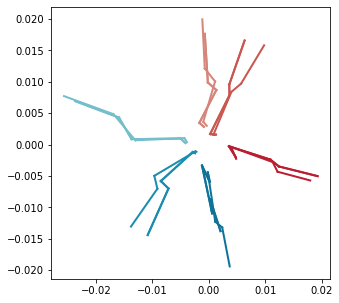

In [7]:
A_est_2D = best_linear_map(concat_dict(train_2d_source),concat_dict(train_2d_target),nns_2d,nn=2)
pts2d_prism = apply_linear_map(A_est_2D, concat_dict(train_2d_target))

ind = 2

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
plot_pose_2d(
    ax, 
    pts2d_prism[ind], 
    bones=par_data["vis"]["bones"], 
    limb_id=par_data["vis"]["limb_id"],  
    colors=par_data["vis"]["colors"], 
    good_keypts=None
)
for i in nns_2d[ind][:2]:
    plot_pose_2d(
        ax, 
        concat_dict(train_2d_source)[i], 
        bones=par_data["vis"]["bones"], 
        limb_id=par_data["vis"]["limb_id"],  
        colors=par_data["vis"]["colors"], 
        good_keypts=None
    )
    
    
#plt.savefig('2D_mapping.svg')

Find best linear transformation for 3D

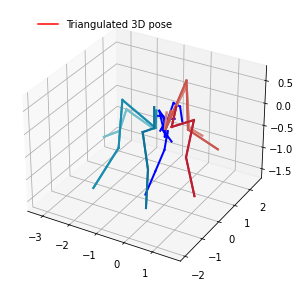

In [9]:
%matplotlib inline
A_est_3D = best_linear_map(concat_dict(train_3d_source),concat_dict(train_3d_target),nns_3d,nn=2)
pts3d_prism = apply_linear_map(A_est_3D, concat_dict(train_3d_source))

t = 2
    
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection="3d")
plot_pose_3d(
    ax, 
    pts3d_prism[ind], 
    bones=par_data["vis"]["bones"], 
    limb_id=par_data["vis"]["limb_id"],  
    #colors=par_data["vis"]["colors"], 
    good_keypts=None
)
for i in nns_3d[ind][:2]:
    plot_pose_3d(
        ax, 
        concat_dict(train_3d_source)[i], 
        bones=par_data["vis"]["bones"], 
        limb_id=par_data["vis"]["limb_id"],  
        colors=par_data["vis"]["colors"], 
        good_keypts=None
    )    
    
#plt.savefig('3D_mapping.svg')

# Train LiftPose3D Network on DeepFly3D Data

In [ ]:
from liftpose.main import train as lp3d_train
from liftpose.lifter.augmentation import add_noise

lp3d_train(train_2d=train_2d, test_2d=test_2d,
           train_3d=train_3d, test_3d=test_3d, 
           train_keypts=train_keypts,
           test_keypts=test_keypts,
           roots=par['roots'],
           target_sets=par['target_sets'],
           out_dir=par['out_dir'],
           network_kwargs={"epochs":10},
           augmentation=[add_noise(noise_amplitude=.1)])

In [ ]:
%matplotlib inline
from liftpose.plot import read_log_train, plot_log_train
epoch, lr, loss_train, loss_test, err_test = read_log_train(par['out_dir'])
plot_log_train(plt.gca(), loss_train, loss_test, epoch)

# Run Trained LiftPose3D Network on the Test Data

In [ ]:
from liftpose.main import test as lp3d_test
lp3d_test(par['out_dir'])

# Visualize Predictions

In [ ]:
from liftpose.postprocess import load_test_results
data = torch.load(os.path.join(par['out_dir'], "test_results.pth.tar"))
stat_2d, stat_3d = (
    torch.load(os.path.join(par['out_dir'], "stat_2d.pth.tar")),
    torch.load(os.path.join(par['out_dir'], "stat_3d.pth.tar")),
)
test_3d_gt, test_3d_pred, good_keypts = load_test_results(data, stat_2d, stat_3d)

In [ ]:
# https://stackoverflow.com/a/38865534/7554774
# conda install ipympl
#%matplotlib widget
%matplotlib inline
from liftpose.plot import plot_pose_3d

fig = plt.figure(figsize=plt.figaspect(1), dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=90, azim=0)

t = 0
plot_pose_3d(ax=ax, tar=test_3d_gt[t], 
            pred=test_3d_pred[t], 
            bones=par_data["vis"]["bones"], 
            limb_id=par_data["vis"]["limb_id"], 
            colors=par_data["vis"]["colors"],
            good_keypts=good_keypts[t])